In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon_EnetV2_OpenMax/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
from dataset import CANDatasetEnet as CANDataset
from rd_openmax import openmax_predict_rd
from model_init import *
from torchvision import transforms
from torch.utils.data import DataLoader


In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device("cuda")

In [6]:
data_close = "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/5_percent/TFRecord_w64_s32/2"
data_open = "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/TFRecord_w64_s32/2"
n_classes = 6
batch_size = 256

In [ ]:
# Configuration
# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_3_cosine_warm
ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_3_cosine_warm/ckpt_epoch_51.pth"
class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_3_cosine_warm/ckpt_classifier_epoch_51.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_51.pth", "weibull_epoch_51.pkl")

In [4]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [40]:
from networks.efficient_net_v2 import ConEfficientNetV2, LinearClassifier
from networks.con_mpncovresnet import ConTinyMPNCOVResNet, LinearClassifier as LinearClassifierMPNCOV
model = ConTinyMPNCOVResNet(
    attention='Cov',
    input_size=64,
    feat_dim=128
)
classifier = LinearClassifier(input_dim=8256, num_classes=n_classes)

ckpt = torch.load(ckpt_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

# 3. Load Weibull models
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means = weibull_data['class_means']
weibull_models = weibull_data['weibull_models']

model.to(device)
classifier.to(device)


LinearClassifier(
  (fc): Linear(in_features=8256, out_features=6, bias=True)
)

In [9]:
# Load datasets
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
close_set = CANDataset(root_dir=data_close, window_size=32, is_train=False, transform=transform)
open_set = CANDataset(root_dir=data_open, window_size=32, is_train=False, transform=transform)

close_loader = torch.utils.data.DataLoader(close_set, batch_size=batch_size, shuffle=False)
open_loader = torch.utils.data.DataLoader(open_set, batch_size=batch_size, shuffle=False)

In [ ]:
total_preds = []
total_labels = []
unk_probs = []
model.eval()
if classifier is not None:
    classifier.eval()

with torch.no_grad():
    for images, labels in open_loader:
        if isinstance(images, (list, tuple)):
            images = images[0]

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # 🧠 Feature embedding
        feats = model.encoder(images) if classifier is not None else model(images)
        feats = F.normalize(feats, dim=1)
        feats_np = feats.cpu().numpy()

        for f, label in zip(feats_np, labels.cpu().numpy()):
            pred_class, unk_prob = openmax_predict_rd(f, class_means, weibull_models)
            total_preds.append((pred_class, unk_prob))
            total_labels.append(label)
            unk_probs.append(unk_prob)



In [46]:
best_thresh = 0.6642  # Threshold for unknown class prediction
# 🔁 Ground-truth mapping: only label 0 is known
mapped_label = [0 if l == 0 else 1 for l in total_labels]

# 🔍 Prediction using OpenMax unknown probability
mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

In [47]:
# 📊 Evaluation
acc = accuracy_score(mapped_label, mapped_pred) * 100
f1 = f1_score(mapped_label, mapped_pred, average='binary')
precision = precision_score(mapped_label, mapped_pred, average='binary', zero_division=0)
recall = recall_score(mapped_label, mapped_pred, average='binary')
conf_matrix = confusion_matrix(mapped_label, mapped_pred)

print(f"Open Set Acc: {acc:.2f}")
print(f"Open Set F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Open Set Acc: 95.68
Open Set F1: 0.7956
Precision: 0.9534
Recall: 0.6826
Confusion Matrix:
[[37369   176]
 [ 1676  3604]]


In [17]:
def plot_confusion_matrix(preds, targets):
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Open-set)')
    plt.show()



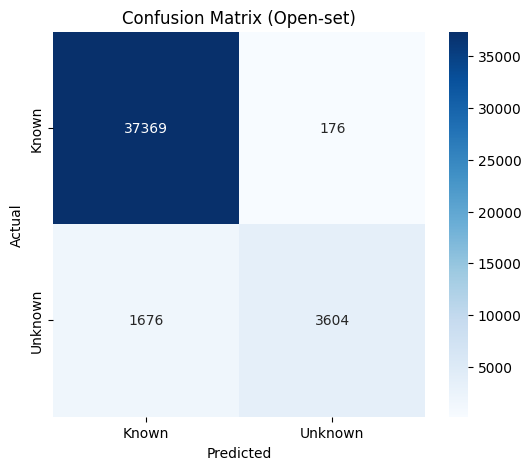

In [49]:
plot_confusion_matrix(mapped_pred, mapped_label)

In [16]:
import pandas as pd
def plot_violin(unk_probs, targets):
    df = pd.DataFrame({
        'Unknown Probability': unk_probs,
        'Class': ['Unknown' if t == 1 else 'Known' for t in targets]
    })

    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Class', y='Unknown Probability', data=df, hue='Class', palette='Set2', legend=False)
    plt.title('Distribution of Unknown Probabilities')
    plt.show()



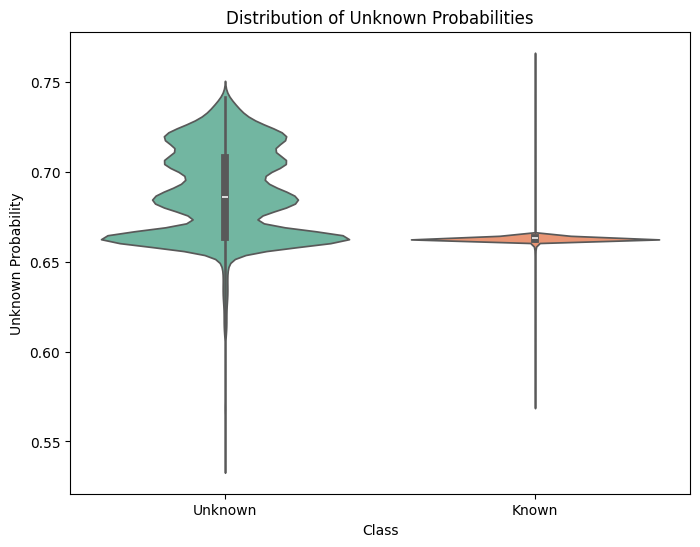

In [52]:
plot_violin(unk_probs, mapped_label)

In [15]:
def plot_roc_curve(pred_probs, targets):
    fpr, tpr, thresholds = roc_curve(targets, pred_probs)
    auc = roc_auc_score(targets, pred_probs)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Open-set Detection')
    plt.legend()
    plt.grid(True)
    plt.show()



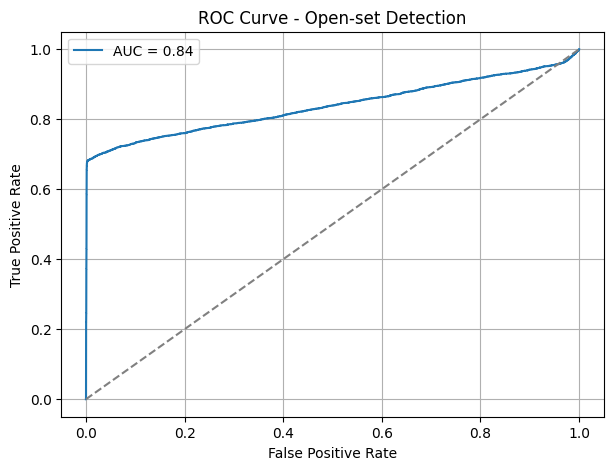

In [54]:
plot_roc_curve([p[1] for p in total_preds], mapped_label)

## Load from other checkpoint

In [22]:
# Configuration
# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_128_trial_1_cosine_warm
# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_2_cosine_warm/ckpt_epoch_57.pth
# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_epoch_91.pth
ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_epoch_107.pth"
class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_classifier_epoch_107.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_107.pth", "weibull_epoch_107.pkl")
data_close = "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/5_percent/TFRecord_w64_s32/2"
data_open = "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/TFRecord_w64_s32/2"
n_classes = 6
batch_size = 256

In [23]:

from networks.con_mpncovresnet import ConTinyMPNCOVResNet, LinearClassifier
model = ConTinyMPNCOVResNet(
    attention='Cov',
    input_size=64,
    feat_dim=128
)
classifier = LinearClassifier(input_dim=8256, num_classes=n_classes)

ckpt = torch.load(ckpt_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

# 3. Load Weibull models
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means = weibull_data['class_means']
weibull_models = weibull_data['weibull_models']

model.to(device)
classifier.to(device)


LinearClassifier(
  (fc): Linear(in_features=8256, out_features=6, bias=True)
)

In [24]:
total_preds = []
total_feats = []
total_labels = []
unk_probs = []
best_thresh = 0.6964  # Threshold for unknown class prediction
model.eval()
if classifier is not None:
    classifier.eval()

with torch.no_grad():
    for images, labels in open_loader:
        if isinstance(images, (list, tuple)):
            images = images[0]

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # 🧠 Feature embedding
        feats = model.encoder(images) if classifier is not None else model(images)
        feats = F.normalize(feats, dim=1)
        feats_np = feats.cpu().numpy()
        total_feats.append(feats_np)
        
        for f, label in zip(feats_np, labels.cpu().numpy()):
            pred_class, unk_prob = openmax_predict_rd(f, class_means, weibull_models)
            total_preds.append((pred_class, unk_prob))
            total_labels.append(label)
            unk_probs.append(unk_prob)

total_feats_np = np.concatenate(total_feats, axis=0)

# 🔁 Ground-truth mapping: only label 0 is known
mapped_label = [0 if l == 0 else 1 for l in total_labels]

# 🔍 Prediction using OpenMax unknown probability
mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

In [14]:
# 📊 Evaluation
acc = accuracy_score(mapped_label, mapped_pred) * 100
f1 = f1_score(mapped_label, mapped_pred, average='binary')
precision = precision_score(mapped_label, mapped_pred, average='binary', zero_division=0)
recall = recall_score(mapped_label, mapped_pred, average='binary')
conf_matrix = confusion_matrix(mapped_label, mapped_pred)

print(f"Open Set Acc: {acc:.2f}")
print(f"Open Set F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Open Set Acc: 96.16
Open Set F1: 0.8235
Precision: 0.9491
Recall: 0.7273
Confusion Matrix:
[[37339   206]
 [ 1440  3840]]


In [25]:
# 📊 Evaluation
acc = accuracy_score(mapped_label, mapped_pred) * 100
f1 = f1_score(mapped_label, mapped_pred, average='binary')
precision = precision_score(mapped_label, mapped_pred, average='binary', zero_division=0)
recall = recall_score(mapped_label, mapped_pred, average='binary')
conf_matrix = confusion_matrix(mapped_label, mapped_pred)

print(f"Open Set Acc: {acc:.2f}")
print(f"Open Set F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Open Set Acc: 95.81
Open Set F1: 0.8120
Precision: 0.9096
Recall: 0.7333
Confusion Matrix:
[[37160   385]
 [ 1408  3872]]


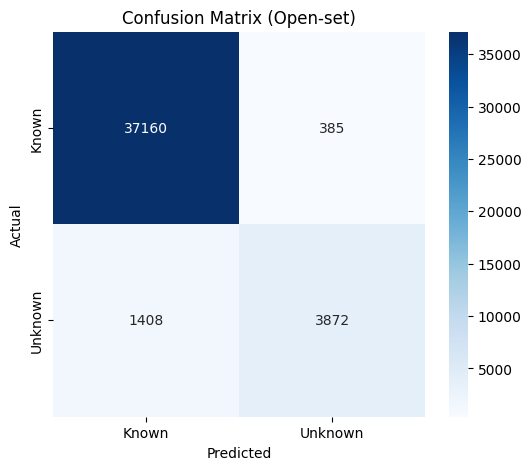

In [26]:
plot_confusion_matrix(mapped_pred, mapped_label)

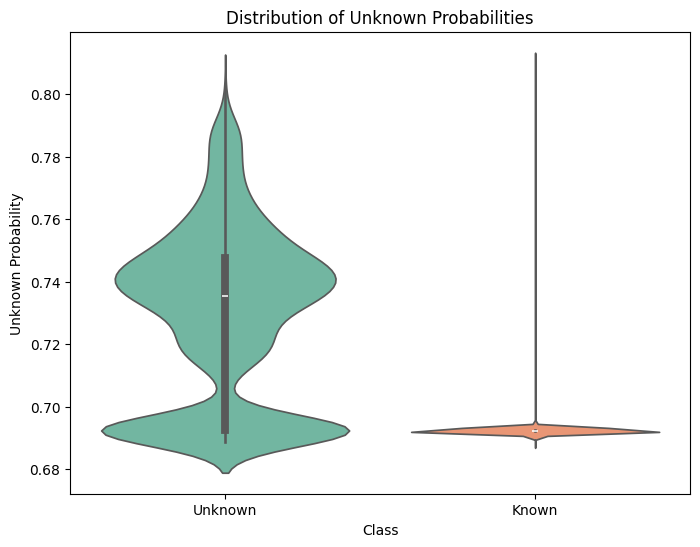

In [27]:
plot_violin(unk_probs, mapped_label)

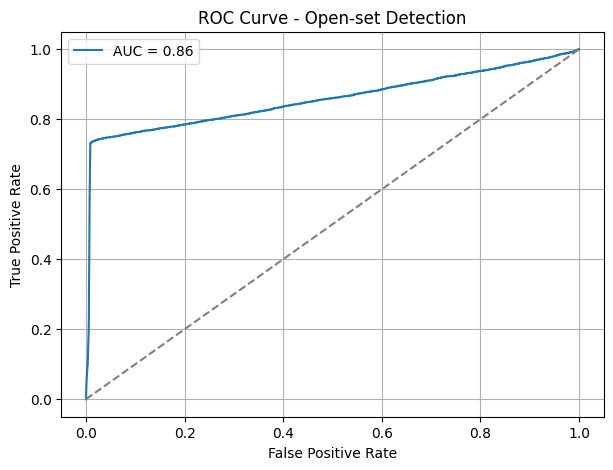

In [28]:
plot_roc_curve([p[1] for p in total_preds], mapped_label)

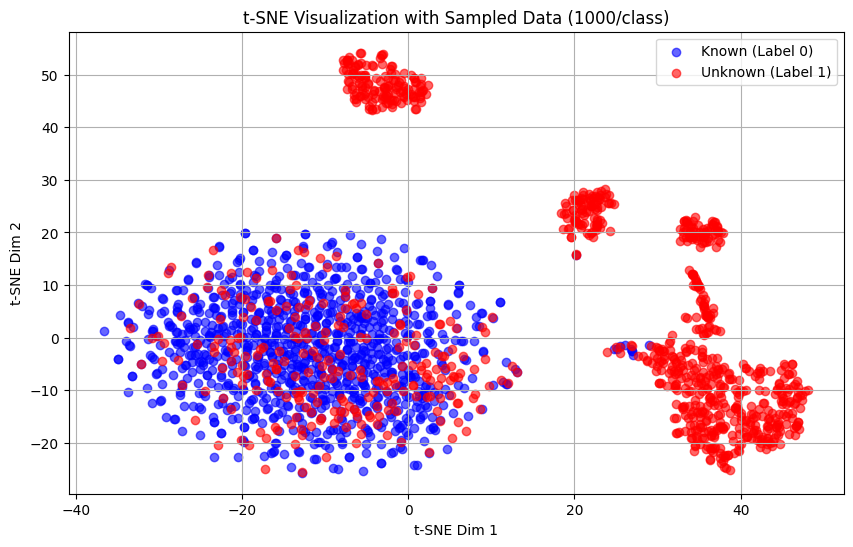

In [29]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ✅ Step 1: Chuyển thành numpy array nếu chưa có
mapped_label_np = np.array(mapped_label)
feats_np = total_feats_np

# ✅ Step 2: Chọn 1000 samples từ mỗi lớp
def subsample_class(feats, labels, target_class, max_samples=1000):
    indices = np.where(labels == target_class)[0]
    if len(indices) > max_samples:
        indices = np.random.choice(indices, size=max_samples, replace=False)
    return feats[indices], labels[indices]

feats_known, labels_known = subsample_class(feats_np, mapped_label_np, target_class=0, max_samples=1000)
feats_unknown, labels_unknown = subsample_class(feats_np, mapped_label_np, target_class=1, max_samples=1000)

# ✅ Step 3: Gộp lại và chạy t-SNE
feats_subset = np.vstack([feats_known, feats_unknown])
labels_subset = np.concatenate([labels_known, labels_unknown])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_feats = tsne.fit_transform(feats_subset)

# ✅ Step 4: Vẽ lại biểu đồ
plt.figure(figsize=(10, 6))
plt.scatter(tsne_feats[labels_subset == 0, 0], tsne_feats[labels_subset == 0, 1],
            c='blue', label='Known (Label 0)', alpha=0.6)
plt.scatter(tsne_feats[labels_subset == 1, 0], tsne_feats[labels_subset == 1, 1],
            c='red', label='Unknown (Label 1)', alpha=0.6)
plt.title('t-SNE Visualization with Sampled Data (1000/class)')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
def subsample_class(feats, labels, preds, target_class, max_samples=1000):
    indices = np.where(labels == target_class)[0]
    if len(indices) > max_samples:
        indices = np.random.choice(indices, size=max_samples, replace=False)
    return feats[indices], labels[indices], preds[indices]

# Chuyển về np.array nếu chưa có
mapped_label_np = np.array(mapped_label)
mapped_pred_np = np.array(mapped_pred)
feats_np = total_feats_np

# Lấy dữ liệu đã lấy mẫu (có cả prediction)
feats_known, labels_known, preds_known = subsample_class(feats_np, mapped_label_np, mapped_pred_np, 0)
feats_unknown, labels_unknown, preds_unknown = subsample_class(feats_np, mapped_label_np, mapped_pred_np, 1)

# Gộp lại
feats_subset = np.vstack([feats_known, feats_unknown])
labels_subset = np.concatenate([labels_known, labels_unknown])
preds_subset = np.concatenate([preds_known, preds_unknown])


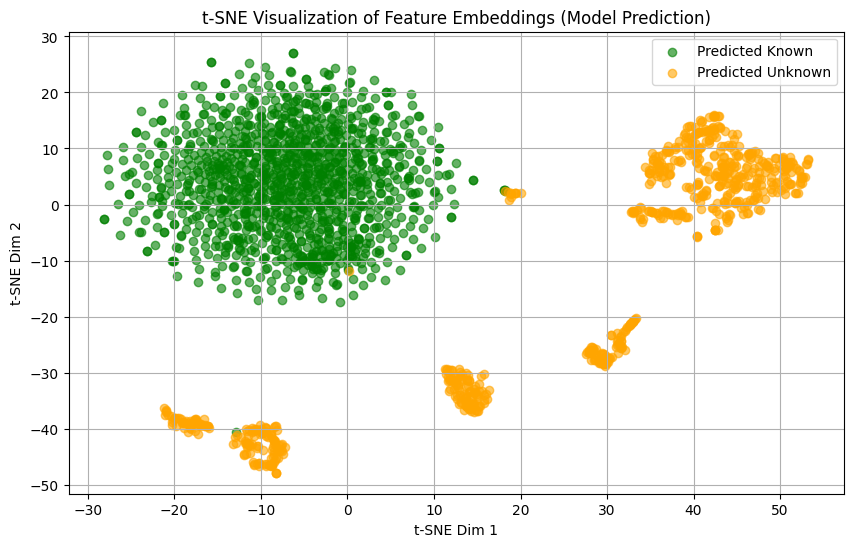

In [41]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_feats = tsne.fit_transform(feats_subset)

# Plot theo dự đoán từ OpenMax
plt.figure(figsize=(10, 6))
plt.scatter(tsne_feats[preds_subset == 0, 0], tsne_feats[preds_subset == 0, 1], 
            c='green', label='Predicted Known', alpha=0.6)
plt.scatter(tsne_feats[preds_subset == 1, 0], tsne_feats[preds_subset == 1, 1], 
            c='orange', label='Predicted Unknown', alpha=0.6)
plt.title('t-SNE Visualization of Feature Embeddings (Model Prediction)')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.metrics import classification_report

# labels_subset = ground-truth (0: known, 1: unknown)
# preds_subset = model prediction (0: known, 1: unknown)
print(classification_report(labels_subset, preds_subset, target_names=["Known", "Unknown"]))


              precision    recall  f1-score   support

       Known       0.78      0.97      0.87      1000
     Unknown       0.97      0.72      0.83      1000

    accuracy                           0.85      2000
   macro avg       0.87      0.85      0.85      2000
weighted avg       0.87      0.85      0.85      2000



In [29]:
from sklearn.metrics import silhouette_score
score = silhouette_score(tsne_feats, preds_subset)
print("Silhouette score:", score)


Silhouette score: 0.5017978
